# Environment configuration

Install packages.

In [ ]:
!pip install transformers --quiet
!pip install datasets transformers[sentencepiece] --quiet
!pip install rouge_score --quiet
!pip install bertviz --quiet
!pip install ecco --quiet

Import packages.

In [ ]:
import pandas as pd
import numpy as np
import transformers as hft 
import datasets as hfd 
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import pickle
import torch
import nltk
import shutil
import tqdm  
import ecco

from transformers.pipelines.base import KeyDataset
from nltk.tokenize import sent_tokenize
from datasets import Dataset
from bertviz import head_view, model_view

from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

Mount GoogleDrive.

In [ ]:
drive.mount('/content/drive')
file = '/content/drive/MyDrive/ml_projects/reddit_tldr/'

Mounted at /content/drive


Set visualization-style.

In [ ]:
plt.style.use('dark_background')

Download rouge-metric & nltk-punkt-package.

In [ ]:
rouge_score = hfd.load_metric("rouge")
nltk.download("punkt")

Downloading:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Model Evaluation

The aim of the model evaluation is to compare the model's performance previously trained in [modelling.iypnb](https://github.com/nielsschluesener/reddit_tldr/blob/main/modelling.ipynb) to other models performances and further investigate the model's predictions.

In order to accomplish this, we firstly set up functions which...
* Create predictions for a given model on a given dataset and calculate metrics
* Compare a metric across different models
* Create detailed visualizations of metrics for one specific model

After that, we will apply the functions to the given test-dataset and the models, which can then be interpreted.

## Set up functions.

The following functions are needed to create standardized predictions for different models, calculate metrics and visualize them.

In [ ]:
def create_eval_dataset(checkpoint_name, df, min_length, max_length):  
  print(f'Setting up model, tokenizer & model for checkpoint {checkpoint_name}.')
  model_checkpoint = checkpoint_name
  tokenizer = hft.AutoTokenizer.from_pretrained(model_checkpoint)
  model = hft.AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
  summarizer = hft.pipeline(task = "summarization", model=model, tokenizer=tokenizer, device = 0, min_length = min_length, max_length = max_length)
  print('Done.')

  print('Create predictions.')
  dataset = Dataset.from_pandas(df)

  outs = []
  for out in summarizer(KeyDataset(dataset, "story"), batch_size=32, truncation="only_first"):
    outs.append(out)
  df['pred_tldr'] = outs

  df['pred_tldr'] = df['pred_tldr'].apply(lambda x: str(x)[18:-2])
  print('Done.')

  print('Calculate ROUGE-Scores.')
  preds_for_rouge = ["\n".join(sent_tokenize(pred.strip())) for pred in df['pred_tldr']]
  trues_for_rouge = ["\n".join(sent_tokenize(pred.strip())) for pred in df['true_tldr']]
  scores = rouge_score.compute(predictions = df['pred_tldr'], references = df['true_tldr'], use_stemmer=True, use_agregator = False)

  for key in scores:
    key_df = pd.DataFrame(scores[key])
    key_df.rename(columns = {'precision': key + '_precision', 'recall': key + '_recall', 'fmeasure': key + '_fmeasure'}, inplace = True)
    df = pd.concat([df, key_df], axis=1)

  df['rouge_avg'] = df[['rouge1_fmeasure','rouge2_fmeasure','rougeL_fmeasure','rougeLsum_fmeasure']].median(axis = 1)
  print('Done.')

  print('Calculate lenghts and length-difference.')
  df['true_length'] = df['true_tldr'].apply(lambda x: len(x))
  df['pred_length'] = df['pred_tldr'].apply(lambda x: len(x))
  df['length_diff'] = df['true_length'] - df['pred_length']
  print('Done.')

  return df

In [ ]:
def compare_metric(eval_list, metric):
  plt.figure(figsize=(8, 5), dpi=80)
  plt.title(f'Comparison of distribution in metric \"{metric}\"', size = 14)

  for e in eval_list:
    plt.hist(e[0][metric], bins = 'auto', alpha=0.5, label = f'{e[1]}: {round(e[0][metric].median(), 3)} Ø') 
    plt.xlim([0, 1])

  plt.legend(loc='upper right')
  plt.show()

In [ ]:
def print_percentile_examples(df, num_examples):
  num_rows = df.shape[0]-1

  for q in [0, 0.25, 0.5, 0.75, 1]:
    print(f'Predictions close to the {q}-percentile:')
    print('')
    e = 0
    for i in range(num_examples):
      print('Rouge-AVG : ' + str(round(df.sort_values('rouge_avg', ascending=True)['rouge_avg'].iloc[int(num_rows*q)+e], 2)) )
      print('Story     : ' + df.sort_values('rouge_avg', ascending=True)['story'].iloc[int(num_rows*q)+e])
      print('True TL;DR: ' + df.sort_values('rouge_avg', ascending=True)['true_tldr'].iloc[int(num_rows*q)+e])
      print('Pred TL;DR: ' + df.sort_values('rouge_avg', ascending=True)['pred_tldr'].iloc[int(num_rows*q)+e])
      print('')

      if q != 1:
        e += 1
      elif q == 1:
        e -= 1
    print('')
    print('')
  

In [ ]:
def vis_rouge_metrics(df):
  rouge_columns = ['rouge1_precision', 'rouge1_recall', 'rouge1_fmeasure',
        'rouge2_precision', 'rouge2_recall', 'rouge2_fmeasure',
        'rougeL_precision', 'rougeL_recall', 'rougeL_fmeasure',
        'rougeLsum_precision', 'rougeLsum_recall', 'rougeLsum_fmeasure']

  fig, axs = plt.subplots(4, 3,figsize=(15,12))

  rc = 0

  for r in range(4):
    for c in range(3):
      x = df[rouge_columns[rc]]
      axs[r,c].hist(x, bins='auto')
      axs[r,c].set_xlim([0, 1])
      axs[r,c].axvline(x.mean(), linestyle='dashed', linewidth=2)
      ylim = axs[r,c].get_ylim()[1]
      axs[r,c].text(0.8, ylim - 0.12 * ylim, '{:.2f} Ø'.format(x.median()), size=12)
      rc += 1

  axs[0, 0].set_title('Precision')
  axs[0, 1].set_title('Recall')
  axs[0, 2].set_title('F1-Measure')
  axs[0, 0].set(ylabel='Rouge 1')
  axs[1, 0].set(ylabel='Rouge 2')
  axs[2, 0].set(ylabel='Rouge L')
  axs[3, 0].set(ylabel='Rouge LSum')

  plt.show()

In [ ]:
def vis_lenghts(df):
  plt.subplots(1, 2, figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.scatter(df['true_length'], df['pred_length'])

  num_min = min(df[["pred_length", "true_length"]].min(axis=0)) * 0.95
  num_max = max(df[["pred_length", "true_length"]].max(axis=0)) * 1.05

  plt.axvline(df['true_length'].mean(), linestyle='dashed', linewidth=0.5, color = 'darkgrey')
  plt.axhline(df['pred_length'].mean(), linestyle='dashed', linewidth=0.5, color = 'darkgrey')

  match_points = [num_min, num_max]
  plt.plot(match_points, match_points, linestyle = 'dotted', linewidth=2, color = 'white')

  plt.xlim(num_min, num_max)
  plt.ylim(num_min, num_max)

  plt.title('TL;DRs length comparison')
  plt.xlabel('Length of true-TL;DRs')
  plt.ylabel('Length of predicted-TL;DRs')

  plt.subplot(1, 2, 2)
  x = df['length_diff']

  plt.hist(x, bins='auto')
  plt.axvline(x.mean(), linestyle='dashed', linewidth=2)
  ylim = plt.ylim()[1]
  xlim = plt.xlim()[1]
  plt.text(xlim - 0.3 * xlim, ylim - 0.12 * ylim, '{:.2f} Ø'.format(x.median()), size=12)
  plt.title('Histogram: Difference in TL;DR-lengths')

  plt.show()

In [ ]:
def vis_cor(df):
  df_cor = df.drop(columns = ['story','true_tldr','pred_tldr'])
  rl_cor = df_cor.corr()

  plt.figure(figsize=(12, 8), dpi=80)

  mask = np.triu(np.ones_like(rl_cor, dtype=np.bool))

  heatmap = sns.heatmap(rl_cor, mask=mask, vmin=-1, vmax=1, annot=True, cmap='mako')
  heatmap.set_title('Correlation heatmap of Rouge-Scores and TL;DRs-Lenghts', fontdict={'fontsize':18}, pad=16);

## Apply functions to evaluate models

### Create predictions and metrics for different models

Load & prep testset.

In [ ]:
testset = pd.read_pickle(file + 'testset.pkl')

In [ ]:
testset.rename(columns={'tldr':'true_tldr'}, inplace = True)
testset = testset.astype(str)
testset = testset.reset_index(drop=True)

#### [BART](https://huggingface.co/docs/transformers/model_doc/bart)

In [ ]:
df_bart = create_eval_dataset('facebook/bart-base', testset, 15, 25)

Setting up model, tokenizer & model for checkpoint facebook/bart-base.


Downloading:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/532M [00:00<?, ?B/s]

Done.
Create predictions.
Done.
Calculate ROUGE-Scores.
Done.
Calculate lenghts and length-difference.
Done.


In [ ]:
df_bart.to_pickle(file + 'predictions_bart.pkl')

#### [T5](https://huggingface.co/docs/transformers/model_doc/t5)-small, without fine-tuning

In [ ]:
df_t5_untuned = create_eval_dataset('t5-small', testset, 15, 25)

Setting up model, tokenizer & model for checkpoint t5-small.


Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

Done.
Create predictions.
Done.
Calculate ROUGE-Scores.
Done.
Calculate lenghts and length-difference.
Done.


In [ ]:
df_t5_untuned.to_pickle(file + 'predictions_t5_untuned.pkl')

#### T5-small, with [fine-tuning](https://github.com/nielsschluesener/reddit_tldr/blob/main/modelling.ipynb)

In [ ]:
shutil.unpack_archive(file + 't5-tuning-checkpoint-best.zip', 't5_fine-tuned')

In [ ]:
df_t5_tuned = create_eval_dataset('t5_fine-tuned', testset, 15, 25)

Setting up model, tokenizer & model for checkpoint t5_fine-tuned.
Done.
Create predictions.
Done.
Calculate ROUGE-Scores.
Done.
Calculate lenghts and length-difference.
Done.


In [ ]:
df_t5_tuned.to_pickle(file + 'predictions_t5_tuned.pkl')

### Compare metrics

Load datasets with predictions.

In [ ]:
df_bart = pd.read_pickle(file + 'predictions_bart.pkl')
df_t5_untuned = pd.read_pickle(file + 'predictions_t5_untuned.pkl')
df_t5_tuned = pd.read_pickle(file + 'predictions_t5_tuned.pkl')

**Reminder: Rouge Scores**

Rouge Scores are a set of metrics used to evaluate summarization-models.

Following explanation from this [link](https://towardsdatascience.com/the-ultimate-performance-metric-in-nlp-111df6c64460).


**Rouge-N**

ROUGE-N measures the number of matching ‘n-grams’ between our model-generated text and a ‘reference’. An n-gram is a grouping of tokens/words. A unigram (1-gram), used for Rouge-1, would consist of a single word. A bigram (2-gram), used for Rouge-2 consists of two consecutive words.

Example for **uni**grams & **bi**grams:

Original: "the quick brown fox jumps over"

Unigrams: ['the', 'quick', 'brown', 'fox', 'jumps', 'over']

Bigrams: ['the quick', 'quick brown', 'brown fox', 'fox jumps', 'jumps over']

In each Rouge-N score, wen can calculate the Recall, Precision and F1-Score.

Recall: number of matching n-grams / number of n-grams in true summary

Precision: number of matching n-grams / number of n-grams in model summary

F1-Score: 2* (precision * recall) / (precision + recall)


**Rouge-L**


ROUGE-L measures the longest common subsequence (LCS) between our model output and reference. All this means is that we count the longest sequence of tokens that is shared between both. Rouge L is computed as the average over each sentence in the summary.

**Rouge-LSum**

ROUGE-LSum is the same as RougeL, but computed over a whole summary instead of each individual sentence.

#### How is the average rouge score (median) among the models?

In [ ]:
eval_list = [[df_bart, 'bart'], [df_t5_untuned, 't5-untuned'], [df_t5_tuned, 't5-tuned']]
metric = 'rouge_avg'

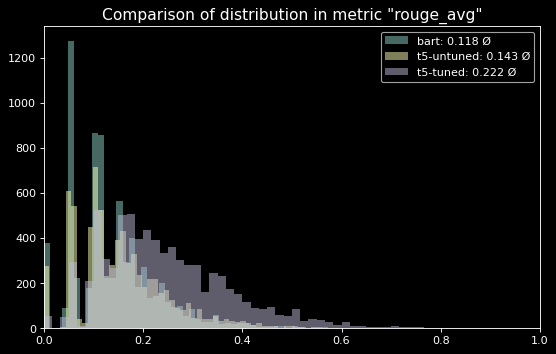

In [ ]:
compare_metric(eval_list, metric)

**Result:** The fine-tuned t5 model outperforms the untuned t5- and standard bart-model, as its predictions have an overall higher ROUGE-score. Additionally we can observe more predictions with a ROUGE-Score > 0.2 made by the tuned t5-model compared to the other models.

### Closer look into the best perfoming model

Since the average rouge score is comprised of many values and additional KPIs can also be considered in the evaluation, we will now examine these for the best performing model.

#### How is each Rouge-Score distributed?

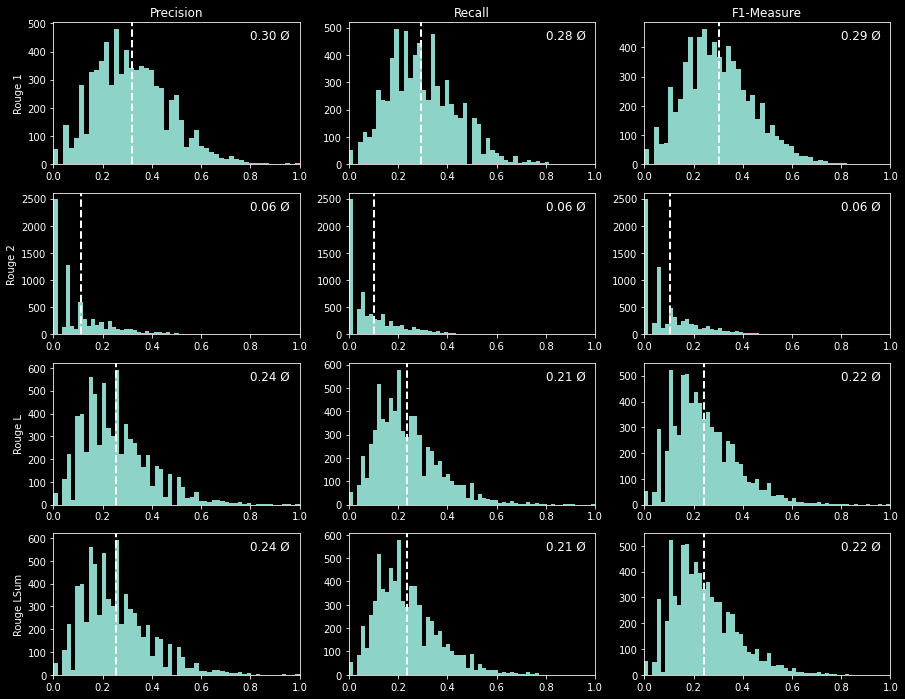

In [ ]:
vis_rouge_metrics(df_t5_tuned)

**Result:** Generally, we can observe differences across the different Rouge-Scores. Rouge-1 is  higher than Rouge-2, which is to be expected, since Rouge-2 requires bigrams-matches which occur less often.

Rouge L and RougeLSum are almost the same. This is probably due to the fact, that we have many one-sentence summarizations where RougeL is always equal to RougeLSum.

Comparing numbers in Precision, Recall and the F1-Measure, only minor differences can be seen.

#### How do generated TL;DRs look like in different levels of quality?

In [ ]:
print_percentile_examples(df_t5_tuned, 3)

Predictions close to the 0-percentile:

Rouge-AVG : 0.0
Story     : summarize: I'm not good with relationships and I've never had a relationship that has lasted more than 6 months. We've been dating for a little over a month and I'm worried that she's a little more emotionally attached to me than I am to her. She's also mentioned that she doesn't want to annoy me and that she doesn't want me to lose interest in her. I'm scared that if I say something wrong, then the relationship may take a turn for the worse. I like her, I enjoy being with her and I'd like the relationship to last as long as it can. Would she be okay if I told her something like "I guess we could mix it up a little and see each other less some weeks"?
True TL;DR: need advice on how to respond to the question in the title of the post
Pred TL;DR: I'm not good with relationships and I don't know if I should tell her something wrong.

Rouge-AVG : 0.0
Story     : summarize: have nearly identical outlooks on what we want fro

**Result:** Investigating individual predictions greatly show how, with increasing Rouge Scores, the predicted and true TL;DR become more and more like each other.

However, we can observe one downsight of the ROUGE-Score: In some of the low-Rouge-Score-Predictions, i would argue, that the model did a good/okay job summarizing the story of the author but did not use the authors words. The ROUGE-Score can not really catch this, as it only looks for word/token similarities. 

Therefore, we should be carful evaluating language model only on the basis of metrics and instead evaluate some predictions manually on top of the metric-based-evaluation to get a better feeling of the models performance. 

#### How is the length (measured in characters) of generated vs. true TL;DRs?

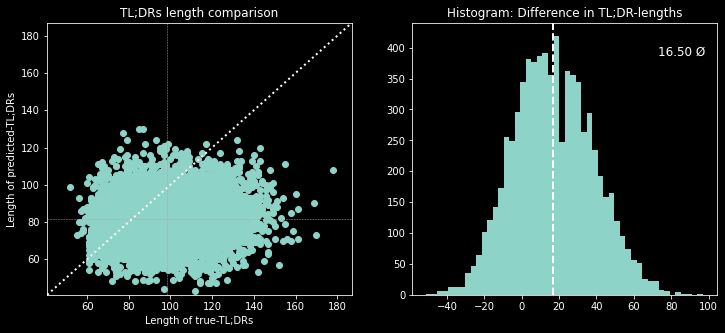

In [ ]:
vis_lenghts(df_t5_tuned)

**Result:** Generally, there are more generated TL;DRs which are shorter than the true TL;DRs (16,5 characters shorter on average). We can not observe a huge variance in the length-differences, because the model is set to produce TL;DRs within a fixed range (15 to 25 tokens).

#### How are the ROUGE-Scores correlated to the lengths / lengths differences?

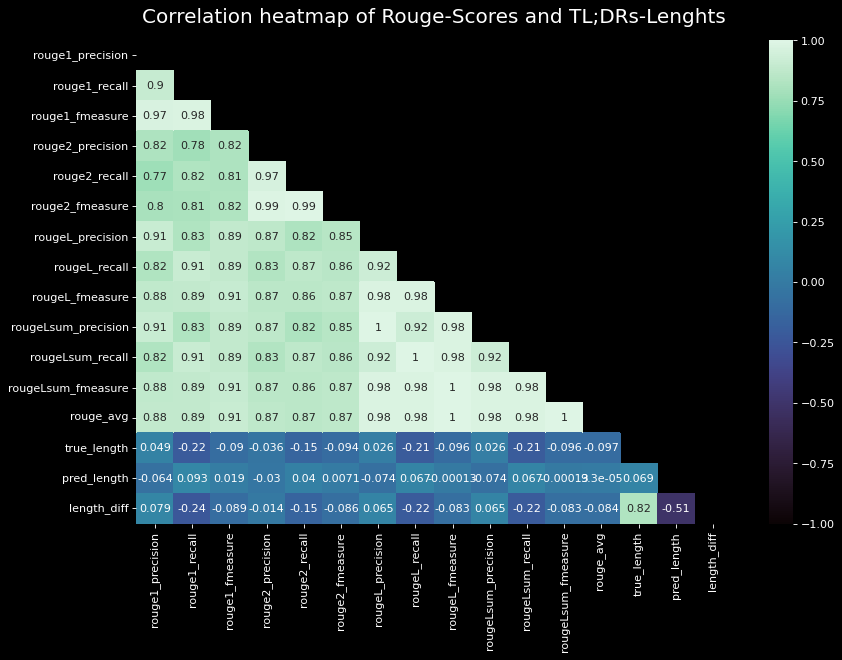

In [ ]:
vis_cor(df_t5_tuned)

**Result:** As expected, the rouge scores correlate strongly with each other. 

One hypothesis of mine was that the lengths of the outputs (predicted and true) correlate with the scores. However, this does not show up in the data. 

# Understanding the model's behaviour

The aim of this part is to get a better understanding of the model and its behaviour when generating the predictions. 

This understanding can be divided into different levels. 

1.   General model knowledge

Understanding the models architecture can be obtained by taking a look into these resources:

* [Transformers, explained! - Video](https://www.youtube.com/watch?v=SZorAJ4I-sA)
* [Fine tuning transformers with huggingface on summarization - Coding Guide](https://huggingface.co/course/chapter7/5?fw=tf)
* [Transformer Model Overview - Blog Post ](https://machinelearningmastery.com/the-transformer-model/)
* [Self attention, step by step - Video](https://www.youtube.com/watch?v=-9vVhYEXeyQ&ab_channel=Peltarion)
* [Coding a transformer from scratch - Blog Post](https://medium.com/swlh/abstractive-text-summarization-using-transformers-3e774cc42453)
* [X-Ray-Transformer Infographic - Infographic / Blog Post](https://towardsdatascience.com/x-ray-transformer-dive-into-transformers-training-inference-computations-through-a-single-visual-4e8d50667378)
* [Attention is all you need - Scientific Paper](https://arxiv.org/pdf/1706.03762.pdf)

Special knowledge about the exact architecture of our fine-tuned t5-small model can be obtained by looking at the **model configuration**. 

Other than that, transformer models do not offer XAI-analysing-tools like 'feature-importance' and thus are hard to explain without the second point...

2.   Individual prediction understanding

In order to obtain an understanding of how individual predictions are created, we can visualize the models **attention blocks with BertViz** and its **feed-fordward neuron activations with Ecco**.

## T5-small-fine-tuned Configuration

How is the model configuration?

In [ ]:
model.config

T5Config {
  "_name_or_path": "t5_fine-tuned",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "early_stopping": true,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "length_penalty": 2.0,
  "max_length": 25,
  "min_length": 15,
  "model_type": "t5",
  "n_positions": 512,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_attentions": true,
  "output_past": true,
  "pad_token_id": 0,
  "prefix": "summarize: ",
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 25,
      "min_length": 15,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translati

**Summarization of the most important config-parameters:**

The model consists of an encoder-decoder architecture. The Encoder has 6 hidden layers in the encoder and 8 attention heads for each attention layer in the Transformer encoder. In the decoder, there are 6 decoding layers.

The minimal length of the output text is set to 15 tokens up to 25 tokens maximum.

## Model's attention with BertViz

**Attention** answers the model's question of: Which part of the inputs should i focus on? For a summarization-task, attention shows how relevant words in the input text are to other words in the same text or in the model-output.

More details on attention can be found here:

* [Calculating self-attention, Step by Step - Video](https://www.youtube.com/watch?v=-9vVhYEXeyQ&t=2s&ab_channel=Peltarion)
* [The Transformer Attention Mechanism - Blog Post](https://machinelearningmastery.com/the-transformer-attention-mechanism/)
* [Attention is all you need - Scientifc Paper](https://arxiv.org/pdf/1706.03762.pdf)


[BertViz](https://github.com/jessevig/bertviz) is an interactive tool for visualizing this attention in Transformer language models such as BERT, GPT2, or T5. Since attention is such an important part of the model in generating predictions, visualizing the attention vectors can help explain the model behavior.

In order to do this, we need to set up the model, tokenizer and summarizer, create a prediction, get the attention-vectors from the model and feed them to BertViz.

Instantiate tokenizer, model, summarizer.

In [ ]:
checkpoint = 't5_fine-tuned'
tokenizer = hft.AutoTokenizer.from_pretrained(checkpoint)
model = hft.AutoModelForSeq2SeqLM.from_pretrained(checkpoint, output_attentions=True)
summarizer = hft.pipeline(task = "summarization", model=model, tokenizer=tokenizer, min_length = 15, max_length = 25)

Load testset and choose short story to evaluate.

We choose the shortest story available, because the length of the input text increases the complexity of the explanation.

In [ ]:
testset = pd.read_pickle(file + 'testset.pkl')
testset.rename(columns={'tldr':'true_tldr'}, inplace = True)
testset = testset.astype(str)
testset = testset.reset_index(drop=True)
testset['story_len'] = testset['story'].apply(lambda x: len(x))

In [ ]:
story = testset.sort_values(by = 'story_len', ascending= True)['story'].iloc[0][11:]

In [ ]:
story

"I don't really have anyone to talk to and I'd like some advice to cope with it. I'm still in love with her and every time I even look at her I fall more and more in love. What's the best course of action for me?"

Create the prediction for this story.

In [ ]:
tldr = str(summarizer(sentence_a))[19:-3]

In [ ]:
tldr

"I'm still in love with my girlfriend and I don't know what to do."

Get attention and input_ids for the story and the TL;DR.

In [ ]:
input_story = tokenizer.encode_plus(story, return_tensors='pt')
tldr_start = input_story['input_ids'].size()[1]

inputs = tokenizer.encode_plus(story, tldr, return_tensors='pt')
input_ids = inputs['input_ids']

In [ ]:
attention = model(decoder_input_ids=input_ids,**inputs)[-1]

In [ ]:
input_id_list = input_ids[0].tolist()
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 

Display attention with BertViz.

The following interactive visualization displays the weights / relevance of tokens to other tokens. By changing the Attention from 'All' to, e.g., Sentence A -> Sentence B, we can investigate how relevant each token of the input text is for the predicted output text. The stronger a line, the bigger the attention.

Due to the fact that the model consists of six attention layers with eight attention heads each, BertViz allows us to filter on each element by either choosing the layer (from 0 to 5) or unselect colors, which represent an attention-head. 

In [ ]:
head_view(attention, tokens, tldr_start)

Output hidden; open in https://colab.research.google.com to view.

**Interpretation:** The method allows for too much insight to be covered here. If you view the notebook in Google Colab, you can play around with it by yourself. :)

However, i want to hightlight one example: 

Comparing the story and the generated TL;DR shows, that the model-generated-TL;DR contains the word 'girlfriend' without its appearance in the input-story. The resulting question is: how did the model come up with that word? The visualized Attention between Sentence A and Sentence B reveals, that there is a strong attention between the input-words 'her' and 'love' and the output word 'girlfriend'. This shows: Based on the words 'her' and 'love', the model concludes, that the author of story is writing about his or her girlfriend.

## Examine feed-fordward neuron activations with [Ecco](https://github.com/jalammar/ecco)

The Feed-Forward Neural Network (FFNN) sublayers are one of the two major components inside a
Transformer block (in addition to the previously examinated attention-blocks). It
often makes up two-thirds of a Transformer block’s
parameters, thus providing a significant portion of
the model’s representational capacity. 

Ecco enables us
to examine neuron activations by collecting them, reduce
their dimensionality to an interpretable amount of dimensions with the Non-negative matrix factorization and visualizes them to extract underlying patterns. It allows us to understand: Which tokens in the text triggers neuron activations?

More about Ecco, including details of their computation, can be found in their publishing-[paper](https://aclanthology.org/2021.acl-demo.30.pdf). 

**Important Note:** Ecco does not support custom / fine-tuned models like our best performing fine-tuned t5-model. Instead, we will examine the standard t5-small model which has the same architecture like our model, and shares a lot of weights, but acts slighty different. Consequently, the results obtained with Ecco about the behavior of the base t5-small-model cannot be transferred 1 to 1 to our fine-tuned model.  

Load t5-small model into Ecco.

In [ ]:
lm = ecco.from_pretrained('t5-small', activations=True)

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

Generate the Ecco-Output for a random text.

In [ ]:
i = np.random.randint(0, testset.shape[0])
story_output = lm.generate(testset.story.iloc[i], generate=1, do_sample=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
nmf_1 = story_output.run_nmf(n_components=15) 
nmf_1.explore()

<IPython.core.display.Javascript object>

**Interpretation:** Hovering over the dimensions on the left side of the visualization highlights the tokens triggering this dimension.

This allows us to understand which tokens in the text activate a group of layers. With 15 target dimensions we can observe that there are groups of layers which are triggered by...

* blank tokens (Dim 1 & 5)
* pronouns of the author: "my, I, me..." (Dim 10)
* pronouns about other people: "her, she, 'this friend'" (Dim 15)
* punctuation (Dim 4 & 9)
* text ending (Dim 7 & 10)
* linking words in the text: "and, even though, without.." (Dim 14)
* parts of the text (Begin of the text in Dim 13, Mid of the text in Dim 2)
* content of the text, without stop-words (Dim 12)

Overall, the visualization can explain some aspects of the model's text processing. However, it can not explain how a certain prediction is generated by the model, because it does not support linking the input- with the output-text.

An additional limitation is given by the fact, that we can not see how well our selected 15 dimensions represent the thousands of neurons in the FF-layers. Instead, i chose the number of dimensions on the ability the interpret them.

 

---



---



End of notebook.